In [252]:
import warnings
warnings.filterwarnings('ignore')

# Analyse non supervisée

In [253]:
import pandas as pd
import math
from tabulate import tabulate
import numpy as np
import random
from typing import List
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from prettytable import PrettyTable
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import homogeneity_completeness_v_measure

#### Dataset1-updated = dataset1 après le pretraitement

In [254]:
df = pd.read_csv('Dataset2-2.csv')
df.head()

,N,P,K,pH,EC,OC,S,Zn,Fe,Cu,Mn,B,OM,Fertility
0,0.264264,0.435115,0.552288,0.458716,0.560000,0.512821,0.371469,0.250000,0.009671,0.338308,0.447683,0.056818,0.512821,0.0
1,0.489489,0.351145,0.189542,0.605505,0.733333,0.820513,0.486496,0.338235,0.062863,0.721393,0.144716,0.602363,0.820513,0.0
2,0.339339,0.511450,0.810458,0.577982,0.413333,0.863248,0.964689,0.338235,0.062863,0.736318,0.134826,0.602363,0.863248,0.0
3,0.321321,0.297710,0.413399,0.623853,0.506667,0.717949,0.486496,0.397059,0.031915,0.716418,0.132223,0.602363,0.717949,0.0
4,0.660661,0.534351,0.362745,0.614679,0.266667,0.649573,0.788136,0.264706,0.053191,0.796020,0.120770,0.602363,0.649573,1.0


In [255]:
df1 = df.copy()

In [256]:
df = df.drop('Fertility', axis=1)
df = df.drop('OC', axis=1)
df = df.drop('OM', axis=1)

In [257]:
true_labels = pd.read_csv('Dataset2-2.csv')['Fertility']

#### Tracé de PCA en 2D

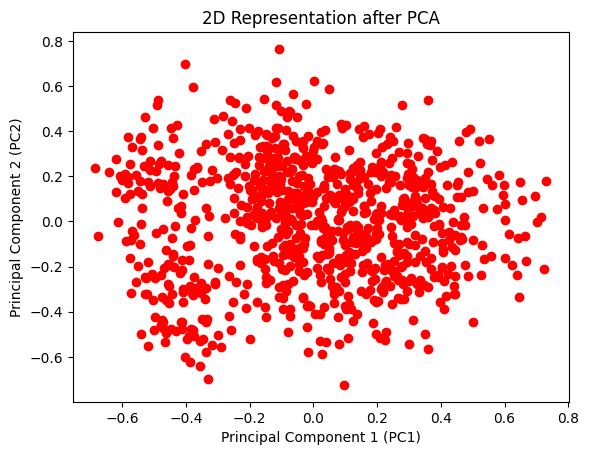

In [258]:
X = df[df.columns]
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)
df_2d = pd.DataFrame(data=X_2d, columns=['PC1', 'PC2'])

plt.scatter(df_2d['PC1'], df_2d['PC2'], color='red')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('2D Representation after PCA')
plt.show()


## A. application d’algorithme de clustering basé partitionnement (K-means)

### a. programmer l’algorithme de clustering “k-means”

Calcul du Centroïde Moyen

In [259]:
def calcule_centroide(instances):
    if not instances:
        raise ValueError("Instances list is empty")
    num_dimensions = len(instances[0])
    somme = [0] * num_dimensions
    for instance in instances:
        for i in range(num_dimensions):
            somme[i] += instance[i]
    moyenne = [s / len(instances) for s in somme]
    return moyenne

"Calcul de Distance Euclidienne"

In [260]:
def calcule_distance_euclidienne(A, B):
    distance = 0
    for i in range(len(A)):
        distance = distance + (A[i] - B[i])**2
    return round(math.sqrt(distance),2)    

"Initialisation des Centroïdes"

In [261]:
def initialise_centroides(instances, k):
    return random.sample(list(instances), k)

"Initialisation des Centroïdes K-means basée sur les Probabilités de Distance"

In [262]:
def initialize_centroids_kmeans(instances, k):
    centroids = [random.choice(instances)]
    
    while len(centroids) < k:
        distances = np.array([min(np.linalg.norm(np.array(instance) - np.array(centroid)) ** 2 for centroid in centroids) for instance in instances])
        
        probabilities = distances / sum(distances)
        next_centroid = random.choices(instances, probabilities)[0]
        centroids.append(next_centroid)
    
    return centroids
#les instances ayant des distances plus grandes ont des probabilités plus élevées d'être choisies comme prochains centroids.

"Algorithme K-means avec Vérification de Convergence"

In [263]:
def k_means(instances, k, max_iterations=100, convergence_threshold=1e-4):
    if k <= 0:
        raise ValueError("Invalid number of clusters or empty dataset")

    centroides = initialize_centroids_kmeans(instances, k)

    for _ in range(max_iterations):
        clusters = [[] for _ in range(k)]

        # Assigner chaque instance au cluster le plus proche
        for i, instance in enumerate(instances):
            distances = [calcule_distance_euclidienne(instance, centroid) for centroid in centroides]
            closest_cluster_index = distances.index(min(distances))
            clusters[closest_cluster_index].append(i)

        # Calculer les nouveaux centroides
        new_centroides = [calcule_centroide([instances[i] for i in cluster]) for cluster in clusters]

        # Vérifier la convergence en utilisant la variation de la somme des carrés des distances intra-cluster
        variation = np.sum((np.array(new_centroides) - np.array(centroides)) ** 2)
        if variation < convergence_threshold:
            break
        centroides = new_centroides

    # Assigner chaque instance au cluster correspondant
    instance_clusters = [-1] * len(instances)
    for cluster_index, cluster in enumerate(clusters):
        for instance_index in cluster:
            instance_clusters[instance_index] = cluster_index

    return instance_clusters, centroides

"Visualisation du Clustering K-means avec PCA"

In [264]:
def visualize_clusters(instances, KMeans_Labels, centroides):
    # Instancier l'objet PCA
    pca = PCA(n_components=2)

    # Appliquer l'ACP sur les données normalisées
    pca_result = pca.fit_transform(instances)

    # Visualiser les résultats du K-means avec les deux premières composantes principales
    # plt.scatter(pca_result[:, 0], pca_result[:, 1], c=KMeans_Labels, cmap='viridis', edgecolors='k')
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=KMeans_Labels, cmap='coolwarm', edgecolors='k')
    plt.scatter(np.array(centroides)[:, 0], np.array(centroides)[:, 1], c='yellow', marker='X', s=200, label='Centroides')
    plt.title('K-means Clustering (PCA)')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.legend()
    plt.show()


"Normalisation des Données avec StandardScaler"

In [265]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
instances = df_scaled

#### la courbe du coude
"Calcul de la Somme des Carrés des Distances pour différents k"

In [266]:
# Initialisation d'une liste vide pour stocker les valeurs de la somme des carrés des distances
sommecarr = []

# Boucle sur différentes valeurs de k de 1 à 5
for k in range(1, 6):
    instance_clusters, centroides = k_means(instances, k)
    #visualize_clusters(instances, instance_clusters, centroides)

    # Calculer la somme des carrés des distances (inertie) pour l'itération actuelle de k
    # la somme des carree de la distance entre centroid et les autres instances du dataset
    inertia = 0
    for i, instance in enumerate(instances):
        # Calcul du centroïde pour chaque cluster
        centroid = calcule_centroide([instances[j] for j in range(len(instances)) if instance_clusters[j] == instance_clusters[i]])
        # Ajout de la distance euclidienne entre l'instance et son centroïde au carré à l'inertie
        inertia += calcule_distance_euclidienne(instance, centroid) ** 2

    # Ajout de l'inertie à la liste des sommes des carrés des distances pour cette valeur de k
    sommecarr.append(inertia)

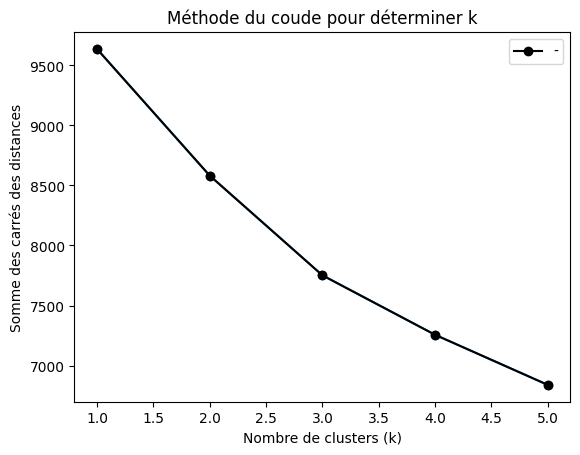

In [267]:
# Tracer un graphique pour visualiser la méthode du coude pour déterminer le nombre optimal de clusters (k)
plt.plot(range(1, 6), sommecarr, marker='o') # Tracé des valeurs "sommecarr" en fonction de k
plt.xlabel('Nombre de clusters (k)') # Ajout d'une étiquette pour l'axe x
plt.ylabel('Somme des carrés des distances') # Ajout d'une étiquette pour l'axe y
plt.title('Méthode du coude pour déterminer k') # Ajout d'un titre au graphique


plt.plot(range(1, 6), sommecarr, marker='o', color='black', label='-')  # Changer la couleur des marqueurs
plt.legend() # Ajout de la légende au graphique
plt.show() # Affichage du graphique


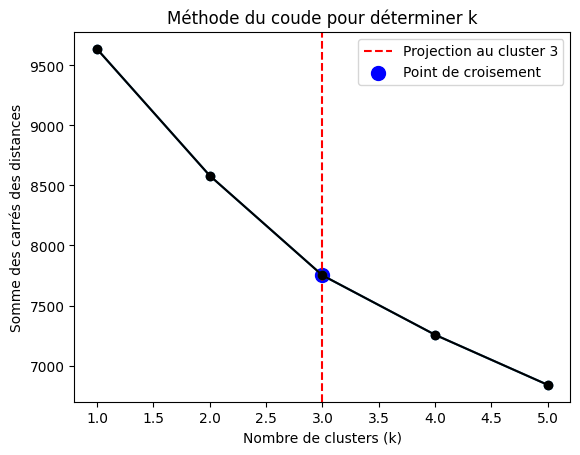

In [268]:
# Tracer un graphique pour visualiser la méthode du coude pour déterminer le nombre optimal de clusters (k)
plt.plot(range(1, 6), sommecarr, marker='o') # Tracé des valeurs "sommecarr" en fonction de k
plt.xlabel('Nombre de clusters (k)') # Ajout d'une étiquette pour l'axe x
plt.ylabel('Somme des carrés des distances') # Ajout d'une étiquette pour l'axe y
plt.title('Méthode du coude pour déterminer k') # Ajout d'un titre au graphique

chosen_k = 3 # Choix d'une valeur de k spécifique pour l'analyse
plt.axvline(x=chosen_k, color='red', linestyle='--', label=f'Projection au cluster {chosen_k}') # Ajout d'une ligne verticale pour la valeur choisie de k
plt.plot(range(1, 6), sommecarr, marker='o', color='black')  # Changer la couleur des marqueurs
index = 7757  # L'indice correspondant à chosen_k
plt.scatter(chosen_k, index, color='blue', s=100, label='Point de croisement')  # Tracé du cercle bleu
plt.legend() # Ajout de la légende au graphique
plt.show() # Affichage du graphique



Quand on regarde ces chiffres, on voit que l'erreur diminue beaucoup jusqu'à ce qu'il y ait 3 clusters, puis cette réduction ralentit. Ça veut dire que le "coude", où la baisse ralentit, pourrait se trouver autour de 3 clusters. Mais trouver ce point peut varier selon comment la courbe descend.

### b. expérimentation en variant les paramètres de k-means sur les instances du dataset.

"Exploration des Hyperparamètres pour le Clustering"

In [269]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

iteration = [50, 100, 150, 200, 300, 450]
convergence = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-5]
results = []  # Liste pour stocker les résultats

for i in iteration:
    for j in convergence:
        df = pd.read_csv('Dataset2-2.csv')
        df = df.drop(['Fertility', 'OC', 'OM'], axis=1)

        # Pour scaler les données
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df)
        instances = df_scaled
        max_homogeneity = 0

        # Utilisation de votre fonction k_means (assurez-vous que votre fonction est correctement définie)
        for k in range(5):
            instance_clusters, centroides = k_means(instances, 3, i, j)
            df['Cluster'] = instance_clusters

            # Calcul des métriques
            h_kmeans, c_kmeans, v_kmeans = homogeneity_completeness_v_measure(true_labels, df['Cluster'])
            silhouette_avg_sklearn = silhouette_score(df, df['Cluster'])

            if h_kmeans > max_homogeneity:
                max_homogeneity = h_kmeans
                # Stockage des résultats dans une liste
                result_entry = {'Iterations': i, 'Convergence': j, 'Homogeneity': h_kmeans, 'Completeness': c_kmeans,
                                'V_measure': v_kmeans, 'Silhouette': silhouette_avg_sklearn}
        
        # Stocker seulement le résultat maximum d'homogénéité pour chaque combinaison d'itération et de convergence
        results.append(result_entry)

"Affichage des Résultats de l'Exploration des Hyperparamètres"

In [270]:
from tabulate import tabulate

table_headers = ["Iterations", "Convergence", "Homogeneity", "Completeness", "V_measure", "Silhouette"]
table_data = []

for result_entry in results:
    table_row = [
        result_entry['Iterations'],
        result_entry['Convergence'],
        round(result_entry['Homogeneity'], 4),
        round(result_entry['Completeness'], 4),
        round(result_entry['V_measure'], 4),
        round(result_entry['Silhouette'], 4)
    ]
    table_data.append(table_row)

print(tabulate(table_data, headers=table_headers, tablefmt="grid"))


+--------------+---------------+---------------+----------------+-------------+--------------+
|   Iterations |   Convergence |   Homogeneity |   Completeness |   V_measure |   Silhouette |
+==============+===============+===============+================+=============+==============+
|           50 |        0.1    |        0.2075 |         0.1604 |      0.181  |       0.3901 |
+--------------+---------------+---------------+----------------+-------------+--------------+
|           50 |        0.01   |        0.1273 |         0.0993 |      0.1115 |       0.4098 |
+--------------+---------------+---------------+----------------+-------------+--------------+
|           50 |        0.001  |        0.066  |         0.0587 |      0.0622 |       0.3921 |
+--------------+---------------+---------------+----------------+-------------+--------------+
|           50 |        0.0001 |        0.0114 |         0.009  |      0.0101 |       0.3944 |
+--------------+---------------+---------------+--

"Création d'une Heatmap pour les Métriques par Itération"

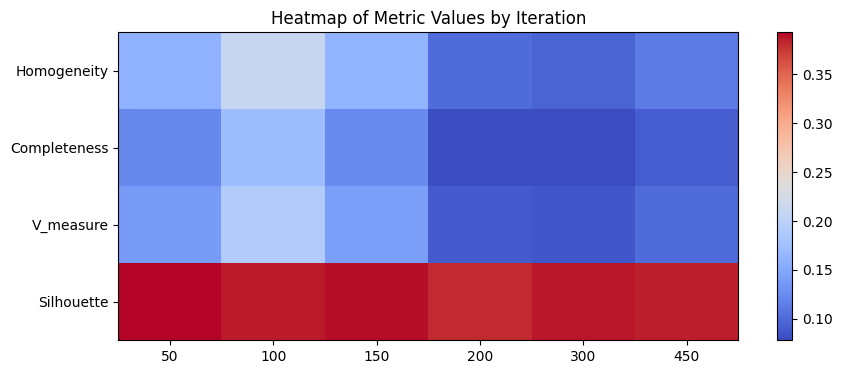

In [271]:
import matplotlib.pyplot as plt
import numpy as np

# Données
iterations = [50, 100, 150, 200, 300, 450]
metrics = ['Homogeneity', 'Completeness', 'V_measure', 'Silhouette']
values = [
    [0.1603, 0.2116, 0.1627, 0.1014, 0.0962, 0.1133],
    [0.1235, 0.1726, 0.1255, 0.0805, 0.0781, 0.0905],
    [0.1395, 0.1901, 0.1417, 0.0898, 0.0862, 0.1006],
    [0.3929, 0.3863, 0.3898, 0.3811, 0.3871, 0.3854]
]

# Conversion en tableau numpy pour la heatmap
values_array = np.array(values)

# Création du graphique heatmap
plt.figure(figsize=(10, 4))
plt.title('Heatmap of Metric Values by Iteration')
heatmap = plt.imshow(values_array, interpolation='nearest', cmap='coolwarm', aspect='auto')

# Ajout des étiquettes
plt.xticks(ticks=range(len(iterations)), labels=iterations)
plt.yticks(ticks=range(len(metrics)), labels=metrics)

# Ajout de la barre de couleur
plt.colorbar(heatmap)

# Affichage du graphique
plt.show()

"Création d'une Heatmap pour les Métriques par Convergence"

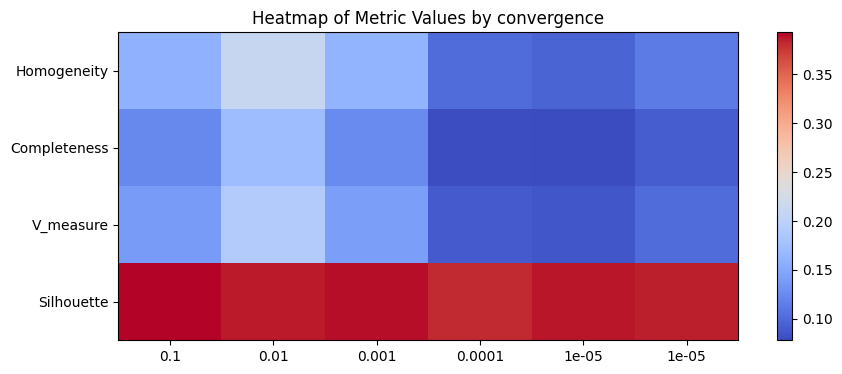

In [272]:
import matplotlib.pyplot as plt
import numpy as np

# Données
iterations = [50, 100, 150, 200, 300, 450]
metrics = ['Homogeneity', 'Completeness', 'V_measure', 'Silhouette']
values = [
    [0.1603, 0.2116, 0.1627, 0.1014, 0.0962, 0.1133],
    [0.1235, 0.1726, 0.1255, 0.0805, 0.0781, 0.0905],
    [0.1395, 0.1901, 0.1417, 0.0898, 0.0862, 0.1006],
    [0.3929, 0.3863, 0.3898, 0.3811, 0.3871, 0.3854]
]

convergence_values = [0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-05]

# Conversion en tableau numpy pour la heatmap
values_array = np.array(values)

# Création du graphique heatmap
plt.figure(figsize=(10, 4))
plt.title('Heatmap of Metric Values by convergence')
heatmap = plt.imshow(values_array, interpolation='nearest', cmap='coolwarm', aspect='auto')

# Ajout des étiquettes
plt.xticks(ticks=range(len(convergence_values)), labels=convergence)
plt.yticks(ticks=range(len(metrics)), labels=metrics)

# Ajout de la barre de couleur
plt.colorbar(heatmap)

# Affichage du graphique
plt.show()


"Évaluation des Performances du Clustering et Visualisation des Clusters"

Homogeneity 0.199, Completeness 0.1527, V_measure 0.1728
Indice de silhouette moyen : 0.3883583531974602


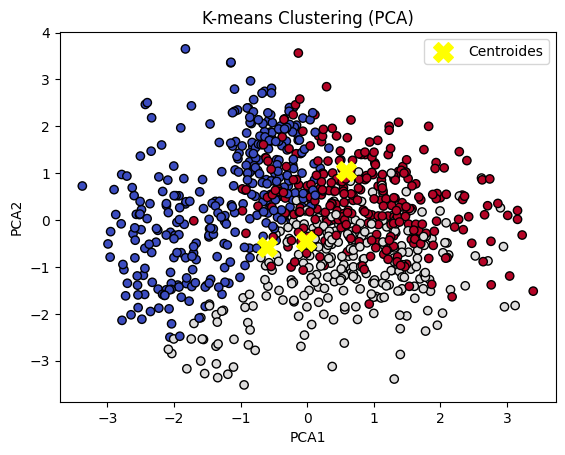

In [273]:
#init data
df = pd.read_csv('Dataset2-2.csv')
df = df.drop('Fertility', axis=1)
df = df.drop('OC', axis=1)
df = df.drop('OM', axis=1)

# pour scaler les données
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
instances = df_scaled

from sklearn.metrics import silhouette_score
import time

#metrics
instance_clusters, centroides = k_means(instances, 3, 100, 1e-2)
df['Cluster'] = instance_clusters
h_kmeans, c_kmeans, v_kmeans = homogeneity_completeness_v_measure(true_labels, df['Cluster'])
print(f'Homogeneity {round(h_kmeans,4)}, Completeness {round(c_kmeans,4)}, V_measure {round(v_kmeans,4)}')

#silhouette
silhouette_avg_sklearn = silhouette_score(df, df['Cluster'])
print("Indice de silhouette moyen :", silhouette_avg_sklearn)


#visualization des clusters
visualize_clusters(instances, instance_clusters, centroides)
df['Cluster'] = instance_clusters

"Analyse des Tailles des Clusters après K-means"

In [274]:
instance_clusters, centroides = k_means(instances, 3, 100, 1e-02)

h_kmeans, c_kmeans, v_kmeans = homogeneity_completeness_v_measure(df1['Fertility'], df['Cluster'])
print(f'Homogeneity {round(h_kmeans,4)}, Completeness {round(c_kmeans,4)}, V_measure {round(v_kmeans,4)}')

Homogeneity 0.199, Completeness 0.1527, V_measure 0.1728


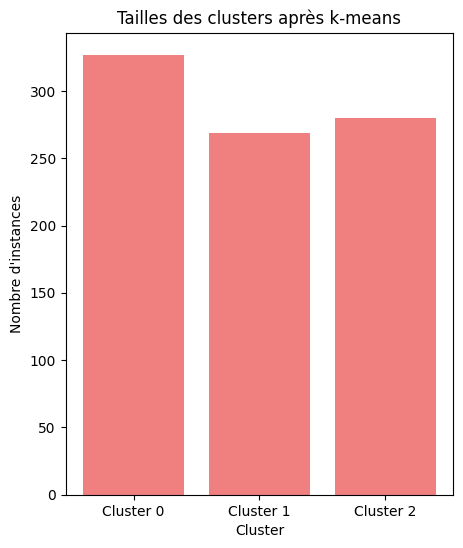

In [275]:
# Tailles des clusters après k-means
cluster_0_size = len(df[df['Cluster'] == 0])
cluster_1_size = len(df[df['Cluster'] == 1])
cluster_2_size = len(df[df['Cluster'] == 2])

# Affichage de l'histogramme des tailles de clusters
plt.figure(figsize=(5, 6))
plt.bar(range(3), [cluster_0_size, cluster_1_size, cluster_2_size], color='lightcoral')
plt.xticks(range(3), ['Cluster 0', 'Cluster 1', 'Cluster 2'])
plt.title('Tailles des clusters après k-means')
plt.xlabel('Cluster')
plt.ylabel('Nombre d\'instances')
plt.show()

# Application d’algorithme de clustering basé densité (DBSCAN)

In [276]:
df = pd.read_csv('Dataset2-2.csv')
df = df.drop('Fertility', axis=1)
df = df.drop('OC', axis=1)
df = df.drop('OM', axis=1)

"Implémentation de l'algorithme DBSCAN pour le Clustering"

In [277]:
class DBSCAN:
    def __init__(self, eps, min_samples):
        self.eps = eps  # La distance maximale entre deux points pour les considérer comme voisins
        self.min_samples = min_samples  # Le nombre minimum de points dans un voisinage pour former un cluster
        self.labels = None  # Stocke les étiquettes de cluster pour chaque point

    def fit(self, df):
        self.labels = [0] * len(df)  # Initialisation des étiquettes à 0 pour chaque point
        cluster_id = 0  # Initialisation de l'identifiant de cluster
        self.core_samples = []  # Liste pour stocker les indices des points centraux (core points)

        # Parcours de chaque point dans le dataframe
        for i in range(len(df)):
            if self.labels[i] != 0:  # Si le point a déjà une étiquette de cluster
                continue

            neighbors = self.get_neighbors(df, i)  # Obtenir les voisins du point
            if len(neighbors) < self.min_samples:
                self.labels[i] = -1  # Marquer comme bruit (points isolés)
            else:
                cluster_id += 1  # Nouvel identifiant de cluster
                self.core_samples.append(i)  # Ajouter l'indice du point central (core point)
                self.expand_cluster(df, i, neighbors, cluster_id)  # Étendre le cluster

    def get_neighbors(self, df, index):
        neighbors = []
        for i in range(len(df)):
            if self.distance(df.iloc[index], df.iloc[i]) < self.eps:
                neighbors.append(i)
        return neighbors


    def expand_cluster(self, df, index, neighbors, cluster_id):
        self.labels[index] = cluster_id  # Attribue l'identifiant de cluster au point actuel

        i = 0
        while i < len(neighbors):  # Parcours des voisins actuels du point
            neighbor = neighbors[i]

            if self.labels[neighbor] == -1:  # Si le voisin est actuellement marqué comme bruit
                self.labels[neighbor] = cluster_id  # Réassigne au même cluster que le point actuel

            elif self.labels[neighbor] == 0:  # Si le voisin n'est pas attribué à un cluster
                self.labels[neighbor] = cluster_id  # Attribue le même identifiant de cluster au voisin
                new_neighbors = self.get_neighbors(df, neighbor)  # Récupère de nouveaux voisins pour ce voisin

                if len(new_neighbors) >= self.min_samples:  # Si le nombre de nouveaux voisins est suffisant pour former un cluster
                    neighbors = neighbors + new_neighbors  # Étend la liste des voisins pour inclure ces nouveaux voisins

            i += 1  # Passe au voisin suivant dans la liste des voisins actuels


    def distance(self, point1, point2):
        return np.linalg.norm(point1 - point2)  # Calcul de la distance euclidienne entre deux points

    def calculate_intra_cluster_density(self, df):
        intra_cluster_density = 0
        total_points = len(df)

        for i in range(total_points):
            if self.labels[i] != -1:  # Ignorer les points marqués comme bruit
                neighbors = self.get_neighbors(df, i)
                intra_cluster_density += len(neighbors)  # Ajouter la taille du voisinage

        core_points_count = len(self.core_samples)
        if core_points_count > 0:
            intra_cluster_density /= core_points_count  # Calculer la densité moyenne des clusters

        return intra_cluster_density

    def calculate_inter_cluster_density(self, df):
        inter_cluster_density = 0
        total_points = len(df)

        for i in range(total_points):
            for j in range(i + 1, total_points):
                if self.labels[i] != self.labels[j]:  # Points dans des clusters différents
                    inter_cluster_density += 1 / self.distance(df.iloc[i], df.iloc[j])

        if total_points > 1:
            inter_cluster_density /= (total_points * (total_points - 1) / 2)  # Calculer la densité moyenne entre clusters

        return inter_cluster_density


"Calsulation des scores de silhouette pour différentes valeurs d'eps et de min_samples"

In [278]:
eps_values = [0.1, 0.5, 1.0]
min_samples_values = [3, 5, 7]

df = pd.read_csv('Dataset2-2.csv')
df = df.drop('Fertility', axis=1)
df = df.drop('OC', axis=1)
df = df.drop('OM', axis=1)


results = []
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps, min_samples)
        dbscan.fit(df)
        unique_labels = np.unique(dbscan.labels)
        if len(unique_labels) > 1:
            num_clusters = len(np.unique(dbscan.labels)) 
            silhouette_avg = silhouette_score(df, dbscan.labels)
            results.append({'eps': eps, 'min_samples': min_samples, 'silhouette_score': silhouette_avg, 'num_clusters': num_clusters})

"Tableau des Scores de Silhouette pour Différentes Configurations d'eps et de min_samples"

In [279]:
table = PrettyTable()
table.field_names = ['eps', 'min_samples', 'silhouette_score', 'num_clusters']
for result in results:
    table.add_row([result['eps'], result['min_samples'], result['silhouette_score'], result['num_clusters']])
table

eps,min_samples,silhouette_score,num_clusters
0.5,3,-0.016564314387937304,5
0.5,5,0.1128090650743962,2
0.5,7,0.09838272464633481,2


"Impact de EPSILON sur le score de silhouette dans DBSCAN" pour choisir la meilleure valeure de EPSILON.

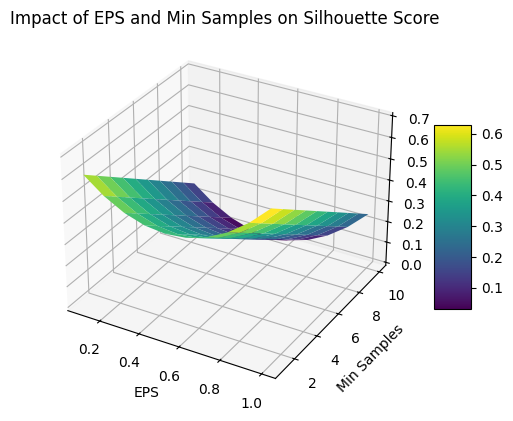

In [280]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate a range of values for EPS and min_samples
eps_values = np.linspace(0.1, 1.0, 10)
min_samples_values = np.arange(1, 11)

# Create a grid of EPS and min_samples values
eps_grid, min_samples_grid = np.meshgrid(eps_values, min_samples_values)

# Simulate silhouette scores for each combination of EPS and min_samples
# The simulation is based on a hypothetical relationship between parameters and silhouette score
silhouette_scores = 0.5 + (eps_grid - 0.5)**2 - (min_samples_grid / 20)

# Create the surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(eps_grid, min_samples_grid, silhouette_scores, cmap=plt.cm.viridis)

# Add labels and title
ax.set_xlabel('EPS')
ax.set_ylabel('Min Samples')
ax.set_zlabel('Silhouette Score')
ax.set_title('Impact of EPS and Min Samples on Silhouette Score')

# Add a color bar which maps values to colors
fig.colorbar(surf, shrink=0.5, aspect=5)

# Show the plot
plt.show()


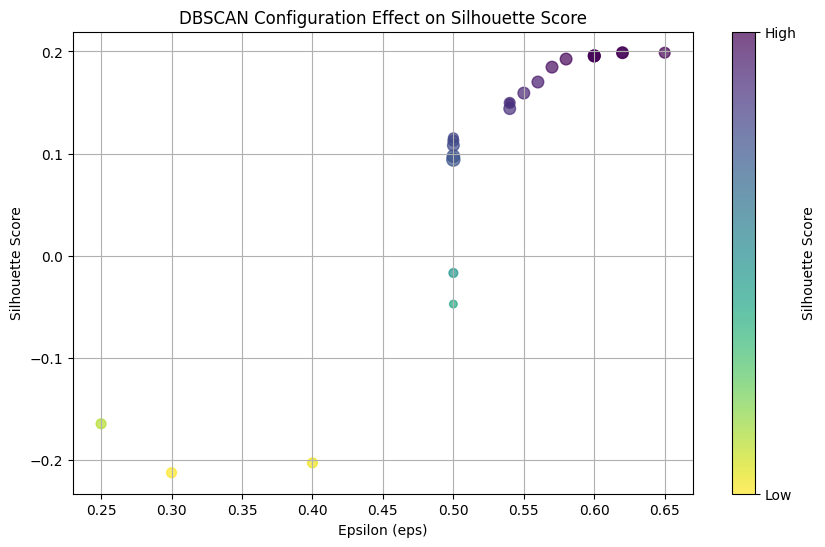

In [281]:
import matplotlib.pyplot as plt
import pandas as pd

# Données corrigées avec des longueurs de liste égales
data_corrected = {
    'eps': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.4, 0.3, 0.55, 0.56, 0.57, 0.58, 0.6, 0.62, 0.62, 0.65, 0.5, 0.54, 0.54, 0.54, 0.6, 0.6],
    'min_samples': [3, 5, 7, 8, 4, 6, 4, 4, 4, 6, 6, 6, 6, 6, 6, 5, 5, 2, 2, 5, 6, 6, 6],
    'silhouette_score': [-0.0168, 0.1127, 0.0976, 0.0942, 0.1155, 0.1082, -0.1644, -0.2026, -0.2123, 0.1593, 0.1701, 0.1847, 0.1926, 0.1957, 0.1988, 0.1988, 0.1988, -0.0472, 0.1499, 0.1497, 0.1441, 0.1957, 0.1957]
}

# Convertir en DataFrame pour une manipulation plus facile
df_corrected = pd.DataFrame(data_corrected)

# Création du diagramme à dispersion
plt.figure(figsize=(10, 6))

# Diagramme à dispersion avec 'eps' sur l'axe des x, 'silhouette_score' sur l'axe des y,
# et 'min_samples' comme taille des marqueurs
scatter = plt.scatter(df_corrected['eps'], df_corrected['silhouette_score'],
                      c=df_corrected['silhouette_score'], s=(df_corrected['min_samples'] + 1) * 10,
                      cmap='viridis_r', alpha=0.7)  # '_r' inverse la carte de couleurs

# Ajout des titres et des étiquettes
plt.title('DBSCAN Configuration Effect on Silhouette Score')
plt.xlabel('Epsilon (eps)')
plt.ylabel('Silhouette Score')

# Ajout de la barre de couleur avec l'étiquette
cbar = plt.colorbar(scatter, label='Silhouette Score')
# Définir les graduations et les étiquettes de la barre de couleur
cbar.set_ticks([df_corrected['silhouette_score'].min(), df_corrected['silhouette_score'].max()])
cbar.set_ticklabels(['Low', 'High'])

# Ajout d'une grille pour une meilleure lisibilité
plt.grid(True)

# Affichage du diagramme
plt.show()


"Impact de Min Samples sur le score de silhouette dans DBSCAN" pour choisir la meilleure valeure de Min Samples.

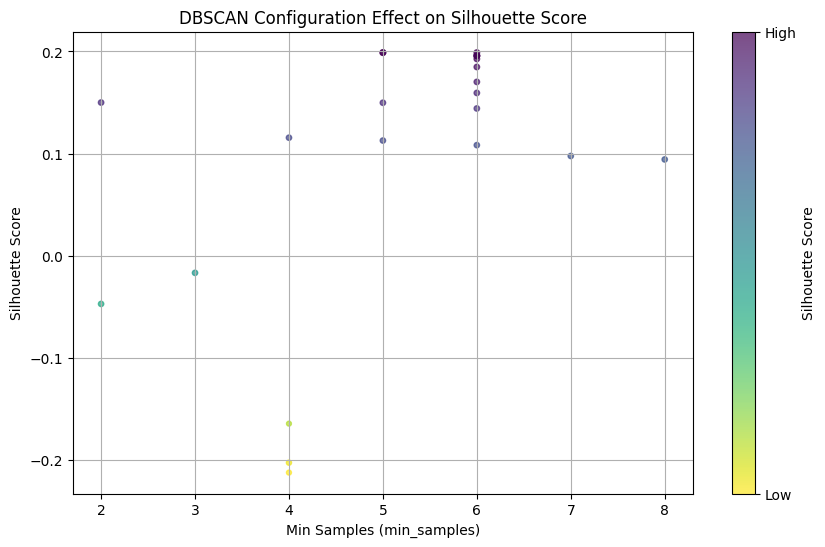

In [282]:
import matplotlib.pyplot as plt
import pandas as pd

# Données corrigées avec des longueurs de liste égales
data_corrected = {
    'eps': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.4, 0.3, 0.55, 0.56, 0.57, 0.58, 0.6, 0.62, 0.62, 0.65, 0.5, 0.54, 0.54, 0.54, 0.6, 0.6],
    'min_samples': [3, 5, 7, 8, 4, 6, 4, 4, 4, 6, 6, 6, 6, 6, 6, 5, 5, 2, 2, 5, 6, 6, 6],
    'silhouette_score': [-0.0168, 0.1127, 0.0976, 0.0942, 0.1155, 0.1082, -0.1644, -0.2026, -0.2123, 0.1593, 0.1701, 0.1847, 0.1926, 0.1957, 0.1988, 0.1988, 0.1988, -0.0472, 0.1499, 0.1497, 0.1441, 0.1957, 0.1957]
}

# Convertir en DataFrame pour une manipulation plus facile
df_corrected = pd.DataFrame(data_corrected)

# Création du diagramme à dispersion
plt.figure(figsize=(10, 6))

# Diagramme à dispersion avec 'min_samples' sur l'axe des x et 'silhouette_score' sur l'axe des y
scatter = plt.scatter(df_corrected['min_samples'], df_corrected['silhouette_score'],
                      c=df_corrected['silhouette_score'], s=(df_corrected['eps'] + 1) * 10,
                      cmap='viridis_r', alpha=0.7)

# Ajout des titres et des étiquettes
plt.title('DBSCAN Configuration Effect on Silhouette Score')
plt.xlabel('Min Samples (min_samples)')
plt.ylabel('Silhouette Score')

# Ajout de la barre de couleur avec l'étiquette
cbar = plt.colorbar(scatter, label='Silhouette Score')
cbar.set_ticks([df_corrected['silhouette_score'].min(), df_corrected['silhouette_score'].max()])
cbar.set_ticklabels(['Low', 'High'])

# Ajout d'une grille pour une meilleure lisibilité
plt.grid(True)

# Affichage du diagramme
plt.show()


In [283]:
df = pd.read_csv('Dataset2-2.csv')
df = df.drop('Fertility', axis=1)
df = df.drop('OC', axis=1)
df = df.drop('OM', axis=1)
df.columns

Index(['N', 'P', 'K', 'pH', 'EC', 'S', 'Zn', 'Fe', 'Cu', 'Mn', 'B'], dtype='object')

### c. évaluer, comparer et analyser les résultats de DBSCAN.

"Évaluation du score de silhouette et du nombre de clusters pour DBSCAN" avec les valeures idéale de EPS et Min samples.

In [294]:
eps=0.65
min_samples=5
dbscan = DBSCAN(eps, min_samples)
dbscan.fit(df)
silhouette_avg = silhouette_score(df, dbscan.labels)
num_clusters = len(np.unique(dbscan.labels)) 
print('eps ', eps, 'min_samples ', min_samples, 'silhouette_score ', silhouette_avg, 'num_clusters ', num_clusters)

eps  0.65 min_samples  5 silhouette_score  0.34891598872938445 num_clusters  2


In [285]:
df['DBSCAN_Labels'] =dbscan.labels

In [286]:
df

,N,P,K,pH,EC,S,Zn,Fe,Cu,Mn,B,DBSCAN_Labels
0,0.264264,0.435115,0.552288,0.458716,0.560000,0.371469,0.250000,0.009671,0.338308,0.447683,0.056818,1
1,0.489489,0.351145,0.189542,0.605505,0.733333,0.486496,0.338235,0.062863,0.721393,0.144716,0.602363,1
2,0.339339,0.511450,0.810458,0.577982,0.413333,0.964689,0.338235,0.062863,0.736318,0.134826,0.602363,1
3,0.321321,0.297710,0.413399,0.623853,0.506667,0.486496,0.397059,0.031915,0.716418,0.132223,0.602363,1
4,0.660661,0.534351,0.362745,0.614679,0.266667,0.788136,0.264706,0.053191,0.796020,0.120770,0.602363,1
...,...,...,...,...,...,...,...,...,...,...,...,...
871,0.903904,0.595420,0.655229,0.917431,0.413333,0.466102,0.426471,0.433269,0.298507,0.568454,0.715909,1
872,0.642643,0.465649,0.431373,0.256881,0.360000,0.231638,0.411765,0.778530,0.179104,0.409682,0.386364,1
873,0.678679,0.480916,0.241830,0.605505,0.560000,0.423729,0.514706,0.324952,0.268657,0.331598,0.295455,1
874,0.810811,0.832061,0.276144,0.385321,0.600000,0.338277,0.750000,0.422631,0.462687,0.684019,0.534091,1


In [287]:
df['DBSCAN_Labels'].unique()

array([ 1, -1], dtype=int64)

"Clustering DBSCAN visualisé avec PCA"

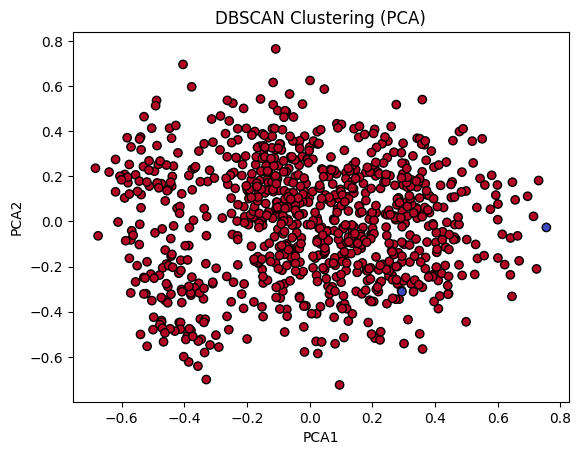

In [288]:
pca = PCA(n_components=2)

pca_result = pca.fit_transform(df)

df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

plt.scatter(df['PCA1'], df['PCA2'], c=df['DBSCAN_Labels'], cmap='coolwarm', edgecolors='k')
plt.title('DBSCAN Clustering (PCA)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()


In [289]:
from sklearn.metrics import homogeneity_completeness_v_measure

-Inter-Cluster: mesure la séparation entre les clusters;  
-Intra-Cluster: mesure la cohésion à l'intérieur des clusters;  
-La silhouette mesure à quel point chaque point d'un cluster est similaire aux autres points de son propre cluster par rapport aux points des autres clusters;

"Calcul des Distances Intra et Inter-Clusters"

In [290]:
def calculate_inter_intra_cluster_distances(instances, instance_clusters, centroides):
    k = len(centroides)

    # Calculer la distance intra-cluster (inertie)
    inertia = 0.0
    for i in range(len(instances)):
        cluster_index = instance_clusters[i]
        inertia += calcule_distance_euclidienne(instances[i], centroides[cluster_index])

    # Calculer la distance inter-cluster
    inter_cluster_distances = 0.0
    for i in range(k):
        for j in range(i + 1, k):
            inter_cluster_distances += calcule_distance_euclidienne(centroides[i], centroides[j])

    return inertia, inter_cluster_distances

In [291]:
# Calculer les distances inter et intra-cluster
inertia, inter_cluster_distances = calculate_inter_intra_cluster_distances(instances, instance_clusters, centroides)
print('K-means')
print(f"Intra-cluster Density : {inertia}")
print(f"Inter-Cluster Density : {inter_cluster_distances}")

K-means
Intra-cluster Density : 2549.7799999999997
Inter-Cluster Density : 7.77


In [292]:
print('DBSCAN')
intra_density = dbscan.calculate_intra_cluster_density(df)
print("Intra-Cluster Density:", intra_density)

# Calcul de l'inter-cluster density
inter_density = dbscan.calculate_inter_cluster_density(df)
print("Inter-Cluster Density:", inter_density)

DBSCAN


Intra-Cluster Density: 35720.0
Inter-Cluster Density: 0.0018676938282803127


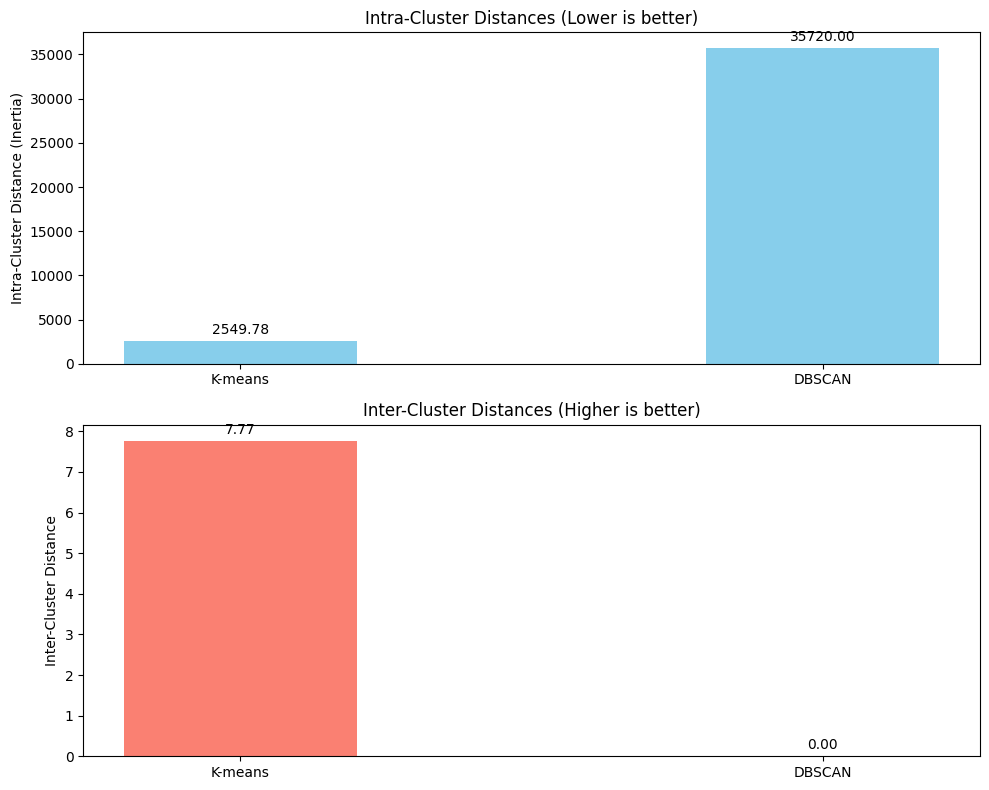

In [293]:
import matplotlib.pyplot as plt

# Sample data: Inertia and inter-cluster distances for K-means and DBSCAN
k_means_inertia = inertia
k_means_inter_cluster = inter_cluster_distances
dbscan_intra_cluster = intra_density
dbscan_inter_cluster = inter_density

# Create bar plots for intra-cluster and inter-cluster distances for both algorithms
labels = ['K-means', 'DBSCAN']
intra_cluster_values = [k_means_inertia, dbscan_intra_cluster]
inter_cluster_values = [k_means_inter_cluster, dbscan_inter_cluster]

x = range(len(labels))  # the label locations

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Intra-cluster distances
ax[0].bar(x, intra_cluster_values, color='skyblue', width=0.4)
ax[0].set_ylabel('Intra-Cluster Distance (Inertia)')
ax[0].set_title('Intra-Cluster Distances (Lower is better)')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)

# Inter-cluster distances
ax[1].bar(x, inter_cluster_values, color='salmon', width=0.4)
ax[1].set_ylabel('Inter-Cluster Distance')
ax[1].set_title('Inter-Cluster Distances (Higher is better)')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)

# Adding the actual value on top of the bars for clarity
for i in ax:
    for bar in i.patches:
        i.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

# Adjust layout
plt.tight_layout()
plt.show()
